# Flamelet Generated Manifold Table Generation (draft) 

In [2]:
using BSplineKit #..derivative of flamelets 
using HDF5 #..importing and exporting data
using Plots

## Introduction 
We wish to: 
1. complement the [FGMFoam tutorial](http://www.tfd.chalmers.se/~hani/kurser/OS_CFD_2019/Michael_Bertsch/report_FGMFoam.pdf) by Michael Bertch (students of Hakan Nillson at Chalmers University) with functionality to generate FGM tables;  
2. employ FGMFOAM to HM1 test case; summary on current results on the [MEGA drive](https://mega.nz/folder/TNlyXToK#XoKa_QIK0Z0CTcuHzdGolw); 

## Section 1:/ Generation of Flamelets data

Generation of (steady or unsteady?) flamelet data using Chem1D (how to obtain?) or [Cantera](www.cantera.org)? Do both employ same nomenclature? Run 1D counterflow diffusion flame for various strain rates.   

Write flamelet data (mass fraction of fuel, oxidizer, combustion products, temperature and mixture fraction) to file.  

A good [Cantera example](./counterflow-diffusion-flame.ipynb) is provided.

## Section 2:/ Post-processing of the flamelet data

1. read flamelet data as function of spatial variable from file; 
2. define progress variabele as linear combination on species mass fraction and temperature; 
3. compute mixture fraction (using Bilger formula in case not computed before);
4. truncate values of x (dependent spatial variable) close to fuel or oxidizer inlet as dependent variables are expected to change little only; 
5. scale dependent variables with molar weight to give e.g. H2 and CH4 same relative importance;
6. define mixture fraction as dependent variable and define interpolation table;
7. write data to file; 

In [26]:
fid = h5open("diffusion_flame.h5", "r")

🗂️ HDF5.File: (read-only) diffusion_flame.h5
└─ 📂 group0
   ├─ 🏷️ Sim1D_type
   ├─ 🏷️ cantera_version
   ├─ 🏷️ curve
   ├─ 🏷️ date
   ├─ 🏷️ energy_enabled
   ├─ 🏷️ fixed_temperature
   ├─ 🏷️ git_commit
   ├─ 🏷️ max_grid_points
   ├─ 🏷️ max_time_step_count
   ├─ 🏷️ prune
   ├─ 🏷️ radiation_enabled
   ├─ 🏷️ ratio
   ├─ 🏷️ slope
   ├─ 🏷️ soret_enabled
   ├─ 🏷️ transport_model
   ├─ 📂 flame
   │  ├─ 🏷️ Domain1D_type
   │  ├─ 🏷️ emissivity_left
   │  ├─ 🏷️ emissivity_right
   │  ├─ 🏷️ name
   │  ├─ 🏷️ steady_abstol
   │  ├─ 🏷️ steady_reltol
   │  ├─ 🏷️ transient_abstol
   │  ├─ 🏷️ transient_reltol
   │  ├─ 🔢 T
   │  ├─ 🔢 X
   │  ├─ 🔢 density
   │  ├─ 🔢 grid
   │  ├─ 🔢 lambda
   │  ├─ 📂 phase
   │  │  ├─ 🏷️ name
   │  │  └─ 🏷️ source
   │  ├─ 🔢 spread_rate
   │  └─ 🔢 velocity
   ├─ 📂 fuel_inlet
   │  ├─ 🏷️ Domain1D_type
   │  ├─ 🏷️ name
   │  ├─ 🔢 T
   │  ├─ 🔢 X
   │  ├─ 🔢 density
   │  ├─ 📂 phase
   │  │  ├─ 🏷️ name
   │  │  └─ 🏷️ source
   │  ├─ 🔢 spread_rate
   │  └─ 🔢 velocity
   └─ 📂 ox

In [27]:
data = read(fid)

Dict{String, Any} with 1 entry:
  "group0" => Dict{String, Any}("oxidizer_inlet"=>Dict{String, Any}("T"=>[300.0…

In [28]:
typeof(data)

Dict{String, Any}

In [29]:
g0 = get(data,"group0",0)

Dict{String, Any} with 3 entries:
  "oxidizer_inlet" => Dict{String, Any}("T"=>[300.0], "X"=>[0.0; 0.0; … ; 0.0; …
  "flame"          => Dict{String, Any}("T"=>[300.0, 300.009, 300.181, 301.203,…
  "fuel_inlet"     => Dict{String, Any}("T"=>[300.0], "X"=>[0.0; 0.0; … ; 0.0; …

In [30]:
typeof(g0)

Dict{String, Any}

In [31]:
flame = get(g0,"flame",0)

Dict{String, Any} with 8 entries:
  "T"           => [300.0, 300.009, 300.181, 301.203, 308.185, 322.518, 357.657…
  "X"           => [0.000125022 0.000555577 … 2.9573e-11 1.78314e-12; 4.08509e-…
  "density"     => [1.22136, 1.22083, 1.21795, 1.21033, 1.17472, 1.11494, 0.995…
  "lambda"      => [-2646.53, -2646.53, -2646.53, -2646.53, -2646.53, -2646.53,…
  "grid"        => [0.0, 0.001, 0.002, 0.0025, 0.003, 0.00325, 0.0035, 0.003625…
  "phase"       => Dict{String, Any}()
  "velocity"    => [0.196502, 0.18556, 0.15288, 0.128926, 0.101868, 0.0892966, …
  "spread_rate" => [7.53744e-20, 11.0278, 22.0649, 27.6293, 33.4641, 36.8762, 4…

In [34]:
mygrid = get(flame,"grid",0) 
moleFraction = get(flame,"X",0)
speciesIndex = 1
data = moleFraction[speciesIndex,:]

96-element Vector{Float64}:
 0.00012502248442636826
 0.0005555770230734533
 0.0023834031715839745
 0.005115360782727435
 0.010757447244864948
 0.015155148458067818
 0.020489699874340628
 0.0234417837877937
 0.026427242385201482
 0.02794785773573174
 0.02945085962418061
 0.032294352889909256
 0.033707546382246246
 ⋮
 0.00011032434144579301
 7.273916984827959e-5
 2.991405020679972e-5
 1.1408560071689077e-5
 4.16776732227953e-6
 1.566652391212678e-6
 2.661713814489809e-7
 4.180296258284184e-8
 7.276294113022406e-9
 4.800533425934244e-10
 2.9573021684161944e-11
 1.7831447657567936e-12

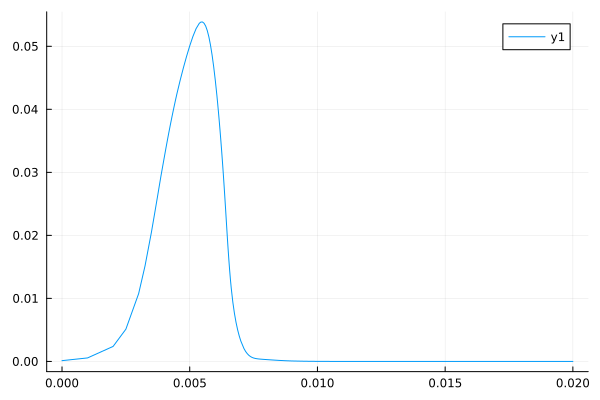

In [36]:
plot(mygrid, data)

In [37]:
 B = BSplineBasis(BSplineOrder(3), mygrid);

In [40]:
?Spline

search: Spline spline Splines BSplines BSplineKit BSplineOrder BSplineBasis



```
Spline
```

Spline function.

---

```
Spline(b::BSplineBasis, coefs::AbstractVector)
```

Construct a spline from a B-spline basis and a vector of B-spline coefficients.

---

```
Spline(undef, B::BSplineBasis, [T=Float64])
```

Construct a spline with uninitialised vector of coefficients.

---

```
(S::Spline)(x)
```

Evaluate spline at coordinate `x`.


In [42]:
(B::Spline).(data)

LoadError: TypeError: in typeassert, expected Spline, got a value of type BSplineBasis{3, Float64, Vector{Float64}}

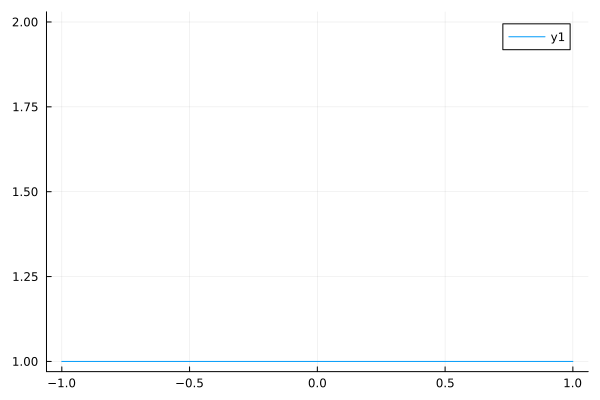

In [43]:
data = S.(-1:0.1:1)
plot(-1:0.1:1, data)

## Section 3:/ Integrate beta-PDF times flamelet and write data to file 

1. read flamelet interpolation data from file; 
2. multiply beta-PDF distribution with flamelet and perform integration (details missing);
3. write data to file;
4. Roekaerts school: integrate beta-PDF; 4-for loop; double loop over alpha and beta (the parameters of the beta-PDF distribution, range?); double loop over mixture fraction and mixture fraction variance; what range in alpha and beta should we consider?   
5. Langella school: perform integration by parts and integrate cumulative beta-PDF. Require derivative of flamelet data that can be computed using cubic-spline interpolation (from the Interpolations.jl package);  

## Section 4:/ Details on (cumulative) beta-PDF distribution 
The [wiki page](https://en.wikipedia.org/wiki/Beta_distribution) on the beta-distribution. 

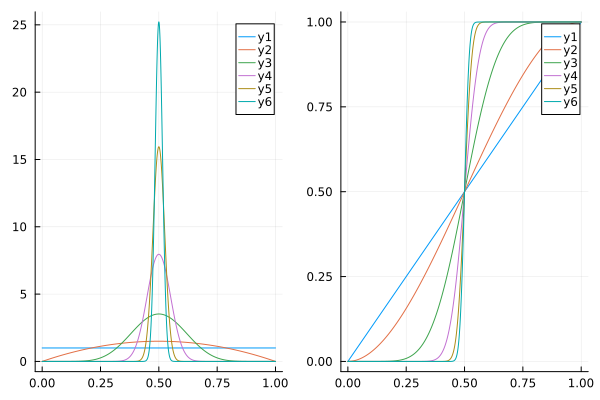

In [6]:
using Distributions
using Plots

#..Define some beta-PDF distributions..
d1 = Beta(1.0,1.0)
d2 = Beta(2.0,2.0)
d3 = Beta(10.0,10.0)
d4 = Beta(50.0,50.0)
d5 = Beta(200.0,200.0)
d6 = Beta(500.0,500.0)

#..Set input argument 
xx = range(0.0,stop=1.0,length=1000)

#..Define plots for the distributions.. 
p1 = plot(xx,pdf.(d1,xx))
p2 = plot!(xx,pdf.(d2,xx))
p3 = plot!(xx,pdf.(d3,xx))
p4 = plot!(xx,pdf.(d4,xx))
p5 = plot!(xx,pdf.(d5,xx))
p6 = plot!(xx,pdf.(d6,xx))

#..Define plots for the cumulative distributions.. 
p7 = plot(xx,cdf.(d1,xx))
p8 = plot!(xx,cdf.(d2,xx))
p9 = plot!(xx,cdf.(d3,xx))
p10 = plot!(xx,cdf.(d4,xx))
p11 = plot!(xx,cdf.(d5,xx))
p12 = plot!(xx,cdf.(d6,xx))

p13=plot(p6, p12, layout = (1, 2))

## References 

1. Diffusion Flamelet Theory with Burke-Schumann relation [slides](https://cefrc.princeton.edu/sites/g/files/toruqf1071/files/Files/2010%20Lecture%20Notes/Norbert%20Peters/Lecture8.pdf)
2. Ansys Fluent Theory Guide on the [flamelet concept](https://www.afs.enea.it/project/neptunius/docs/fluent/html/th/node156.htm); 
3. wiki on [laminar flamelet model](https://en.wikipedia.org/wiki/Laminar_flamelet_model);
4. Diffusion Flamelet in z-resolution [demo](https://cerfacs.fr/chemistry-repo/pub/cantera_jypnb/CDF-Flamelet.html) in Cantera; 
5. discussion on CFD-Online OpenFoam on the [FGM model](https://www.cfd-online.com/Forums/openfoam-programming-development/73210-fgm-combustion-model.html); 
6. discussion on CFD-Online ConvergeCFD on the [HM1 test case](https://www.cfd-online.com/Forums/converge/237310-application-fgm-hm1-test-case-inquiry-dimauro2021.html);